# Metabolic Model Simulations and Parameter Exploration

George-David Apostolidis, Aadreeta Biswas, Jeroen Mieras

This notebook contains all simulations and analyses used in the study.
Here we implement the full four-variable ODE model for Glc, PEP, PYR, and OAA,
estimate its parameters using the available experimental time-series data,
and explore the behaviour of the reduced PEP–PYR system under different
assumptions about cellular energy availability.

The notebook is divided into the following parts:

1. **Model Definition**  
   Implementation of the ODEs based on the metabolic reactions described in the project.  
   The energy term φ is included as specified in the model formulation.

2. **Parameter Estimation**  
   We run a coarse parameter search using Latin Hypercube Sampling (LHS) to scan
   biologically plausible ranges for OAA(0), d, and φ₀.  
   Each parameter set is evaluated by comparing simulations to the experimental PEP and PYR data.

3. **Fine Grid Search**  
   After locating a promising region of parameter space, we perform a refined grid search
   around the best LHS sample to obtain the final parameter estimates used in the reduced model.

4. **Model Reduction**  
   The system is reduced to the two key variables (PEP and PYR) by applying a quasi–steady-state
   assumption for OAA and treating Glc as depleted after its initial decline.

5. **Phase-Plane Analysis**  
   We generate vector fields, nullclines, and trajectories of the reduced model to examine
   whether the system supports growth-like or dormant-like behaviour under different φ-functions.

6. **Dormancy Escape Experiments**  
   Simulations are performed under low-energy conditions to test whether the reduced model can
   transition out of a dormant state.  
   We also evaluate a modified φ(PEP) feedback formulation to explore whether positive feedback
   enables reactivation.

All results in the report can be reproduced by running the cells in this notebook in order.
The code is written to be self-contained so that no external setup is required beyond the
data files provided.


### ODEs of the Given Reactions

We define the full four-dimensional ODE system describing the dynamics of  
glucose (Glc), phosphoenolpyruvate (PEP), pyruvate (PYR), and oxaloacetate (OAA).  
The equations correspond to:

$$
\frac{d[\mathrm{Glc}]}{dt} = - r \varphi \, \mathrm{Glc}
$$

$$
\frac{d[\mathrm{PEP}]}{dt} = r\varphi(\mathrm{Glc} + \mathrm{OAA}) +
\varphi\,\mathrm{PYR} - (1+\varphi+d)\,\mathrm{PEP}
$$

$$
\frac{d[\mathrm{PYR}]}{dt} = r\varphi\,\mathrm{OAA} +
\varphi\,\mathrm{PEP} - (\varphi + d)\,\mathrm{PYR}
$$

$$
\frac{d[\mathrm{OAA}]}{dt} = \mathrm{PEP} - \varphi\,\mathrm{OAA}
$$


## **Task 1 — Parameter Estimation Using the Full Four-Variable Model**

In this task, we estimate the parameters of the full kinetic model of *E. coli* core carbon metabolism using the provided experimental datasets. These datasets consist of time-series measurements of PEP and PYR for three different growth conditions, corresponding to  
$$ r \in \{1,\, 0.1,\, 0.01\}. $$

### **Loading Data and Preparing the Simulation Environment**

We begin by loading the experimental PEP and PYR trajectories and constructing a simulation time grid spanning 0–10 hours. These trajectories serve as the reference against which model predictions will be compared. Required Python packages are imported, and access to the dataset directory is initialized.

### **Full Four-Variable ODE Model**

The model tracks the concentrations of glucose (Glc), phosphoenolpyruvate (PEP), pyruvate (PYR), and oxaloacetate (OAA). Metabolic fluxes are regulated by the energy-dependent term  
$$ \varphi = \max(1 - \mathrm{PYR},\, \varphi_0), $$  
which captures the influence of cellular energy status on metabolic activity. This full ODE system is used for parameter fitting and later serves as the basis for constructing reduced models.

### **Scoring Function for a Single Dataset**

To quantify how well a given parameter set matches the data, we compute a weighted least-squares error between simulated and experimental PEP/PYR trajectories. The model output is interpolated to the experimental time points, and deviations are penalized using measurement variances.

### **Global Scoring Across All Conditions**

Because the biochemical parameters should not depend on the external growth-rate factor \( r \), we define a **global score** by summing the errors across all three datasets. Minimizing this combined score yields a single consistent parameter set valid for all experimental conditions.

### **Coarse Parameter Search via Latin Hypercube Sampling (LHS)**

We first explore the parameter space globally using Latin Hypercube Sampling. This method efficiently distributes samples across multidimensional ranges:

- $$ \mathrm{OAA}(0) \in [0, 10], $$
- $$ \log_{10}(d) \in [-9, -6], $$
- $$ \varphi_0 \in [0, 1]. $$

For each sample, the global error is evaluated, and the best-performing region of parameter space is identified.

### **Fine Grid Search Around the Best LHS Parameters**

After identifying the most promising region, we refine the parameter estimate using a dense local grid search. This step improves accuracy and yields the final best-fit values for  
$$ \mathrm{OAA}(0),\; d,\; \text{and}\; \varphi_0. $$

### **Simulation and Visualization of Best-Fit Dynamics**

Using the best-fit parameters, we simulate the model for all values of  
$$ r \in \{1,\, 0.1,\, 0.01\} $$  
and compare the predicted PEP and PYR dynamics to the experimental data. The results are displayed in a single combined figure with three rows (one per \( r \)) and two columns (PEP and PYR). This visualization illustrates how well the fitted model captures the system's behaviour and highlights any remaining discrepancies.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.stats import qmc
import math

# ================================
# Load datasets from local folder
# ================================
file_r1   = "core_metabolism_r1.csv"
file_r01  = "core_metabolism_r01.csv"
file_r001 = "core_metabolism_r001.csv"

data_time, PEP_mean1,  PEP_sd1,  PYR_mean1,  PYR_sd1  = np.loadtxt(file_r1,   delimiter=",", unpack=True)
data_time, PEP_mean01, PEP_sd01, PYR_mean01, PYR_sd01 = np.loadtxt(file_r01,  delimiter=",", unpack=True)
data_time, PEP_mean001,PEP_sd001,PYR_mean001,PYR_sd001 = np.loadtxt(file_r001, delimiter=",", unpack=True)

print("Datasets loaded from local directory: r = 1, 0.1, 0.01")

# Simulation time grid
t_sim = np.linspace(0, 10, 1001)


Mounted at /content/drive
Datasets loaded: r = 1, 0.1, 0.01


In [ ]:
def ode_function(state, t, r, d, phi0):
    Glc, PEP, PYR, OAA = state

    # Energy status function: φ = max(1 − PYR, φ0)
    phi = max(1 - PYR, phi0)

    dGlc_dt = - r * phi * Glc
    dPEP_dt = r * phi * (Glc + OAA) + phi * PYR - PEP * (1 + phi + d)
    dPYR_dt = r * phi * OAA + phi * PEP - PYR * (phi + d)
    dOAA_dt = PEP - phi * OAA

    return [dGlc_dt, dPEP_dt, dPYR_dt, dOAA_dt]

def score_single_dataset(OAA0, d, phi0,
                         mean_PEP, sd_PEP,
                         mean_PYR, sd_PYR,
                         r):
    """
    Scoring function. It calculates the score for each set
    of initial conditions (only changing OAA(0)) and parameters
    (only changing d and phi0).
    """
    # Initial conditions
    Glc0 = 1
    PEP0 = mean_PEP[0]
    PYR0 = mean_PYR[0]

    init = [Glc0, PEP0, PYR0, OAA0]

    # Solve ODE
    sol = odeint(ode_function, init, t_sim, args=(r, d, phi0))
    PEP_sim = sol[:,1]
    PYR_sim = sol[:,2]

    # Interpolate to match experimental time points
    PEP_interp = interp1d(t_sim, PEP_sim)(data_time)
    PYR_interp = interp1d(t_sim, PYR_sim)(data_time)

    # Weighted least squares
    score = np.sum((mean_PEP - PEP_interp)**2 / sd_PEP**2) + \
            np.sum((mean_PYR - PYR_interp)**2 / sd_PYR**2)

    return score
def global_score(params):
    """
    Adding up the scores the model for the same parameter set but
    with differing r values. In other words, the model needs to be
    good for all r values.

    params = [OAA0, log10(d), phi0]
    """

    OAA0, logd, phi0 = params
    d = 10**logd

    total = 0

    # r = 1
    total += score_single_dataset(
        OAA0, d, phi0,
        PEP_mean1, PEP_sd1,
        PYR_mean1, PYR_sd1,
        r=1
    )

    # r = 0.1
    total += score_single_dataset(
        OAA0, d, phi0,
        PEP_mean01, PEP_sd01,
        PYR_mean01, PYR_sd01,
        r=0.1
    )

    # r = 0.01
    total += score_single_dataset(
        OAA0, d, phi0,
        PEP_mean001, PEP_sd001,
        PYR_mean001, PYR_sd001,
        r=0.01
    )

    return total

def print_parameters(title, params, score):
    """
    Writing down the best found initial condition and parameter set.
    """
    OAA0 = params[0]
    logd = params[1]
    phi0 = params[2]
    d = 10**logd

    print(f"\n===== {title} =====")
    print(f"OAA(0) = {OAA0:.6f}  mM")
    print(f"d      = {d:.6e}  h^-1  (log10(d) = {logd:.6f})")
    print(f"phi0   = {phi0:.6f}")
    print(f"Score  = {score:.3f}")


In [ ]:
sampler = qmc.LatinHypercube(d=3)
N = 2000
raw = sampler.random(N)

# Bounds:
# OAA0 ∈ [0, 10]
# log10(d) ∈ [-9, -6]
# phi0 ∈ [0, 1]

OAA_vals  = 0   + raw[:,0] * (10 - 0)
logd_vals = -9  + raw[:,1] * (-6 + 9)
phi_vals  = 0   + raw[:,2] * (1 - 0)

samples = np.column_stack([OAA_vals, logd_vals, phi_vals])

best_score = np.inf
best_params = None

for i, ps in enumerate(samples):
    score = global_score(ps)

    if score < best_score:
        best_score = score
        best_params = ps

    if i % 200 == 0:
        print(f"Checked {i}/{N} samples. Current best score = {best_score:.2f}")

print_parameters("COARSE LHS BEST PARAMETERS", best_params, best_score)

Checked 0/2000 samples. Current best score = 3994507.49
Checked 200/2000 samples. Current best score = 400658.35
Checked 400/2000 samples. Current best score = 400658.35
Checked 600/2000 samples. Current best score = 400533.86
Checked 800/2000 samples. Current best score = 400533.86
Checked 1000/2000 samples. Current best score = 400142.74
Checked 1200/2000 samples. Current best score = 400142.74
Checked 1400/2000 samples. Current best score = 400142.74
Checked 1600/2000 samples. Current best score = 400142.74
Checked 1800/2000 samples. Current best score = 400142.74

===== COARSE LHS BEST PARAMETERS =====
OAA(0) = 1.047512  mM
d      = 5.857170e-09  h^-1  (log10(d) = -8.232312)
phi0   = 0.128087
Score  = 400142.740


In [ ]:
# Set initial parameter set guess
best_OAA, best_logd, best_phi = best_params

# Build a narrower search grid around the coarse best point
# Set bounds to be a specific value different from the initial (best) parameter set guess
OAA_grid  = np.linspace(max(0,  best_OAA  - 1), min(10, best_OAA  + 1), 20)
logd_grid = np.linspace(best_logd - 0.3, best_logd + 0.3, 20)
phi_grid  = np.linspace(max(0,  best_phi  - 0.1), min(1,  best_phi  + 0.1), 20)

fine_samples = np.array(np.meshgrid(OAA_grid, logd_grid, phi_grid)).T.reshape(-1,3)

best_score_fine = np.inf
best_params_fine = None

for ps in fine_samples:
    score = global_score(ps)
    if score < best_score_fine:
        best_score_fine = score
        best_params_fine = ps

print_parameters("FINAL BEST PARAMETERS", best_params_fine, best_score_fine)



===== FINAL BEST PARAMETERS =====
OAA(0) = 1.100144  mM
d      = 2.935539e-09  h^-1  (log10(d) = -8.532312)
phi0   = 0.133350
Score  = 400041.709


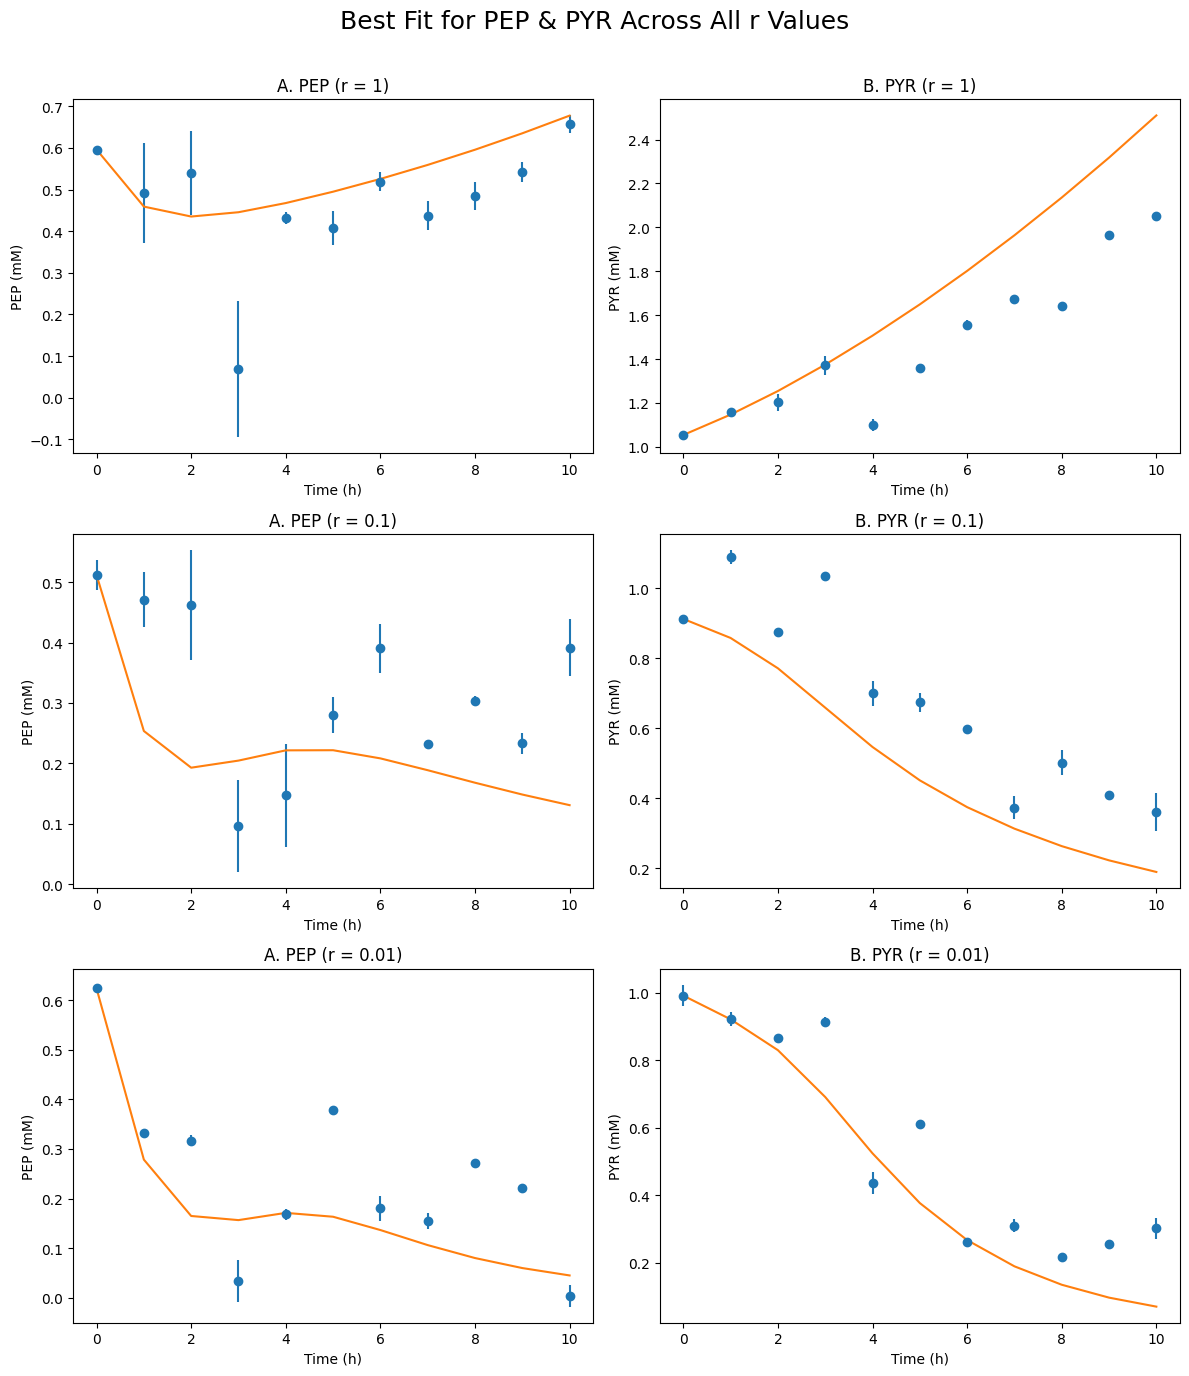

Saved figure as combined_best_fit.jpg


In [ ]:
def simulate(best_params, r):
    OAA0, logd, phi0 = best_params
    d = 10**logd

    # initial values from each dataset
    if r == 1:
        PEP0 = PEP_mean1[0]
        PYR0 = PYR_mean1[0]
    elif r == 0.1:
        PEP0 = PEP_mean01[0]
        PYR0 = PYR_mean01[0]
    else:
        PEP0 = PEP_mean001[0]
        PYR0 = PYR_mean001[0]

    init = [1, PEP0, PYR0, OAA0]
    sol = odeint(ode_function, init, t_sim, args=(r, d, phi0))
    return sol


fig, axs = plt.subplots(3, 2, figsize=(12, 14))
fig.suptitle("Best Fit for PEP & PYR Across All r Values", fontsize=18)

plot_settings = [
    (1,    PEP_mean1,  PEP_sd1,  PYR_mean1,  PYR_sd1,  "r = 1"),
    (0.1,  PEP_mean01, PEP_sd01, PYR_mean01, PYR_sd01, "r = 0.1"),
    (0.01, PEP_mean001,PEP_sd001,PYR_mean001,PYR_sd001,"r = 0.01")
]

for idx, (r, mean_PEP, sd_PEP, mean_PYR, sd_PYR, title_text) in enumerate(plot_settings):

    sol = simulate(best_params_fine, r)
    PEP_sim = sol[:,1]
    PYR_sim = sol[:,2]

    PEP_interp = interp1d(t_sim, PEP_sim)(data_time)
    PYR_interp = interp1d(t_sim, PYR_sim)(data_time)

    ax1 = axs[idx, 0]
    ax1.errorbar(data_time, mean_PEP, yerr=sd_PEP, fmt='o')
    ax1.plot(data_time, PEP_interp, '-')
    ax1.set_title(f"PEP ({title_text})")
    ax1.set_xlabel("Time (h)")
    ax1.set_ylabel("PEP (mM)")

    ax2 = axs[idx, 1]
    ax2.errorbar(data_time, mean_PYR, yerr=sd_PYR, fmt='o')
    ax2.plot(data_time, PYR_interp, '-')
    ax2.set_title(f"PYR ({title_text})")
    ax2.set_xlabel("Time (h)")
    ax2.set_ylabel("PYR (mM)")

plt.tight_layout(rect=[0, 0, 1, 0.97])

# Save as JPEG
plt.savefig("combined_best_fit.jpg", dpi=300)
plt.show()

print("Saved figure as combined_best_fit.jpg")


## **Task 2 — Construction and Analysis of a Simplified Two-Variable Model**

To study the structural dynamics of the system and explore its qualitative behaviour, we reduce the full model to a simplified system involving only PEP and PYR. This reduction is motivated by the observation that Glc depletes rapidly, while OAA adjusts more quickly than the PEP–PYR subsystem.

### **Construction of the Simplified Two-Variable Model**

We analyse three reduced formulations with different assumptions about the energy-regulation term:

1. Fixed energy level:  
   $$ \varphi = \varphi_0, $$

2. Linearly decreasing energy availability:  
   $$ \varphi = 1 - \mathrm{PYR}, $$

3. The assignment-specified hybrid form:  
   $$ \varphi = \max(1 - \mathrm{PYR},\, \varphi_0). $$

These alternative formulations allow us to examine how different assumptions about energy regulation affect system dynamics.

### **Nullclines and Phase-Plane Analysis Tools**

We implement general-purpose functions for computing nullclines and phase-plane vector fields for any two-variable ODE system. Nullclines indicate where  
$$ \dot{\mathrm{PEP}} = 0 \quad \text{and} \quad \dot{\mathrm{PYR}} = 0, $$  
while vector fields reveal the directional flow of trajectories. Together, these tools are used to predict fixed points, assess stability, and classify dynamical regimes.

### **Fitted Parameters and Phase-Plane Exploration**

To connect the reduced model with biological reality, we apply the best-fit parameters obtained from Task 1. This allows us to study how the simplified system behaves under physiologically relevant parameter values and evaluate whether it can reproduce features such as growth-like trajectories or approaches to dormancy.

### **Plotting the Model**

For each of the three conditions  
$$ r \in \{1,\, 0.1,\, 0.01\}, $$  
we generate phase-plane plots comparing the two energy-regulation assumptions:

- $$ \varphi = 1 - \mathrm{PYR}, $$
- $$ \varphi = \varphi_0. $$

Each figure shows the nullclines and the associated vector field, enabling a side-by-side comparison of how the simplified model behaves under different growth conditions. These visualizations help determine whether the reduced system supports trajectories corresponding to fast growth or metabolic dormancy.


In [ ]:
def simplified_model_1_PYR(state, t, r, d, phi0):
    PEP, PYR = state

    # added dynamic phi, as described in the assignment
    phi = 1 - PYR

    dPEP_dt = r * PEP + phi * PYR - PEP * (1 + phi + d)

    dPYR_dt = r * PEP + phi * PEP - PYR * (phi + d)

    return [dPEP_dt, dPYR_dt]

In [ ]:
def simplified_model_phi0(state, t, r, d, phi0):
    PEP, PYR = state

    # added dynamic phi, as described in the assignment
    phi = phi0

    dPEP_dt = r * PEP + phi * PYR - PEP * (1 + phi + d)

    dPYR_dt = r * PEP + phi * PEP - PYR * (phi + d)

    return [dPEP_dt, dPYR_dt]

In [ ]:
def simplified_model(state, t, r, d, phi0):
    PEP, PYR = state

    # added dynamic phi, as described in the assignment
    phi = np.maximum(1 - PYR, phi0)

    dGlc_dt = 0

    dPEP_dt = r * PEP + phi * PYR - PEP * (1 + phi + d)

    dPYR_dt = r * PEP + phi * PEP - PYR * (phi + d)

    return [dPEP_dt, dPYR_dt]

In [ ]:
def nullclines(ode, pars, xlim, ylim, labels = ['Nullcline x','Nullcline y'], npointsx = 100, npointsy = 100):
    x_range = np.linspace(xlim[0],xlim[1],npointsx)
    y_range = np.linspace(ylim[0],ylim[1],npointsy)
    X,Y = np.meshgrid(x_range,y_range)

    dXdt = ode([X,Y],0,*pars)
    dxdt = dXdt[0]
    dydt = dXdt[1]

    C = plt.contour(X,Y,dxdt, levels = [0], colors = ['cyan'])
    plt.plot([],[],color = 'cyan',label = labels[0])

    C = plt.contour(X,Y,dydt, levels = [0], colors = ['red'], linestyles = ['--'])
    plt.plot([],[],color = 'red', linestyle = '--', label = labels[1])
    plt.xlabel('$x$')
    plt.ylabel('$y$')

In [44]:
def pplane(ode, pars, xlim, ylim, npointsx = 13, npointsy = 13, rescale_arrows = True):
    x_range = np.linspace(xlim[0],xlim[1],npointsx)
    y_range = np.linspace(ylim[0],ylim[1],npointsy)
    X,Y = np.meshgrid(x_range,y_range)

    dXdt = ode([X,Y],0,*pars)

    U = np.copy(dXdt[0])
    V = np.copy(dXdt[1])
    if rescale_arrows:
        length = np.sqrt(U**2 + V**2)
        with np.errstate(divide='ignore', invalid='ignore'):
            U /= length
            V /= length

    plt.quiver(X, Y, U, V, color="black", alpha=0.8, linewidth=0.8)


In [45]:
OAA0_fit = 1.011495 # mM
d_fit      = 1.084762e-09 # h^-1  (log10(d) = -8.964665)
phi0_fit   = 0.136305 # mM
Score  = 400059.278

In [46]:
r1 = 1
r01 = 0.1
r001 = 0.01
parameters_fitted_r1 = [r1, d_fit, phi0_fit]
parameters_fitted_r01 = [r01, d_fit, phi0_fit]
parameters_fitted_r001 = [r001, d_fit, phi0_fit]

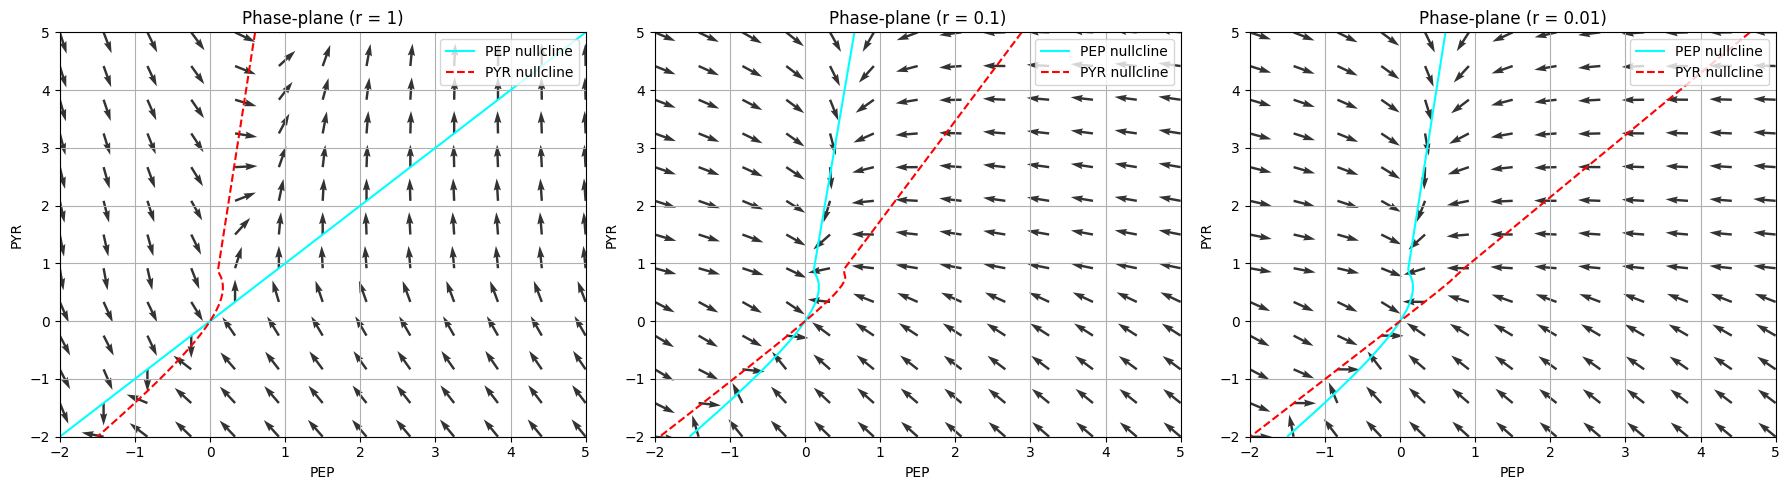

In [47]:
def plot_phaseplanes_merged_same_style(d, phi0):
    r_values = [1, 0.1, 0.01]
    xlim = (-2, 5)
    ylim = (-2, 5)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    for idx, r_value in enumerate(r_values):
        ax = axes[idx]
        plt.sca(ax)

        parameters = (r_value, d, phi0)

        nullclines(simplified_model, parameters, xlim, ylim)
        pplane(simplified_model, parameters, xlim, ylim)

        ax.set_title(f"Phase-plane (r = {r_value})")
        ax.set_xlabel("PEP")
        ax.set_ylabel("PYR")
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid(True)
        ax.legend()

    plt.tight_layout()
    plt.show()


# Run the merged figure
plot_phaseplanes_merged_same_style(d_fit, phi0_fit)


## **Task 3 — Dormancy Dynamics and Wake-Up Mechanisms in the Reduced Model**

In this task, we investigate whether the reduced two-variable PEP–PYR model can reproduce the emergence of dormant states and, importantly, whether the system is capable of transitioning out of dormancy under low-energy conditions. This analysis is motivated by the biological observation that dormant bacterial cells can sometimes resume growth when perturbed or supplied with additional energy sources.

### **Part 1 — Behaviour of the Simple Reduced Model at Low Energy**

We begin by analysing the simplified model under a very low baseline energy level,
$$ \varphi_0 \ll 1. $$
Such conditions represent cells with limited ATP/ADP availability, consistent with dormancy.

The model is simulated from several initial conditions, including states with extremely low PEP and PYR concentrations—characteristic of dormant or metabolically inactive cells. All simulations are performed over a long time frame (200 hours) to observe slow relaxation dynamics.

Across all tested initial conditions, the trajectories collapse onto a single low-PEP, low-growth state. This indicates that the simplified model lacks a mechanism for spontaneous “wake-up” and cannot exit dormancy once the system enters this regime. Biologically, this corresponds to a cell that remains trapped in a low-energy state without the ability to reactivate.

### **Part 2 — Introducing a Positive Feedback Mechanism to Enable Wake-Up**

To overcome this limitation, we introduce a modified regulatory function in which the energy status increases with PEP concentration:
$$
\varphi(P) = \varphi_0 + \frac{\alpha\, P}{K + P}.
$$

This creates a positive feedback loop:
- A small increase in PEP raises \( \varphi \),
- which boosts metabolic flux,
- which further increases PEP.

Such feedback is well known to generate **bistability**, allowing the system to possess both dormant and active states depending on initial conditions.

We compare two scenarios:

1. A deeply dormant initial state,  
   $$ (PEP_0,\, PYR_0) = (0.01,\, 0.01), $$  
   which remains trapped in the low-energy basin.

2. A slightly “kicked” initial condition,  
   $$ (PEP_0,\, PYR_0) = (0.6,\, 0.1), $$  
   representing a biochemical or environmental perturbation.

The modified model shows that the kicked trajectory successfully transitions into a high-PEP, growth-like state, while the dormant trajectory remains inactive. This demonstrates that adding feedback enables **wake-up behaviour**, where dormancy is no longer an irreversible attractor.

### **Merged Visualization of Both Dynamics**

We present a merged figure that juxtaposes:

- The simple reduced model under low energy (left panel)
- The modified model showing dormancy versus wake-up (right panel)

This side-by-side comparison clearly illustrates the difference in dynamical behaviour and highlights the role of energy-dependent feedback in enabling escape from dormancy. Such mechanisms may be relevant to understanding how dormant bacterial cells transition back to growth under favourable conditions.


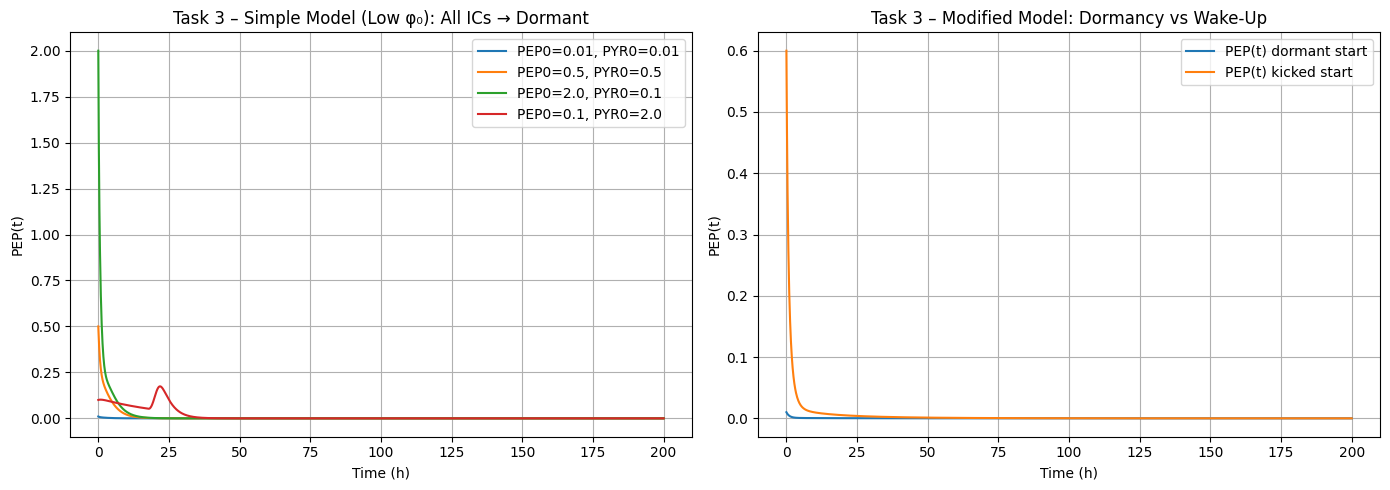

In [ ]:
# ==========================================================
# MERGED FIGURE for Task 3 Part 1 + Part 2
# ==========================================================

from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Shared parameters
phi0_low = 0.05
r_example = 0.1
d = d_fit
t_long = np.linspace(0, 200, 2000)

# ---------------------------
# PART 1 — simple model
# ---------------------------

ICs = [
    [0.01, 0.01],   # dormant
    [0.5,  0.5 ],
    [2.0,  0.1 ],
    [0.1,  2.0 ]
]

# ---------------------------
# PART 2 — modified model
# ---------------------------

def phi_P(PEP, phi0, alpha, K):
    return phi0 + alpha * PEP / (K + PEP + 1e-12)

def modified_model(state, t, r, d, phi0, alpha, K):
    PEP, PYR = state
    phi = phi_P(PEP, phi0, alpha, K)
    dPEP_dt = r * PEP + phi * PYR - PEP * (1 + phi + d)
    dPYR_dt = r * PEP + phi * PEP - PYR * (phi + d)
    return [dPEP_dt, dPYR_dt]

alpha = 0.8
K = 0.5

state_dorm = [0.01, 0.01]
state_kick = [0.6,  0.1 ]

sol_dorm = odeint(modified_model, state_dorm, t_long,
                  args=(r_example, d, phi0_low, alpha, K))
sol_kick = odeint(modified_model, state_kick, t_long,
                  args=(r_example, d, phi0_low, alpha, K))

# ==========================================================
# Create merged figure
# ==========================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ---------------------------
# LEFT PANEL — Part 1
# ---------------------------
ax = axes[0]

for P0, Y0 in ICs:
    sol = odeint(simplified_model, [P0, Y0], t_long,
                 args=(r_example, d, phi0_low))
    ax.plot(t_long, sol[:, 0], label=f"PEP0={P0}, PYR0={Y0}")

ax.set_title("Task 3 – Simple Model (Low φ₀): All ICs → Dormant")
ax.set_xlabel("Time (h)")
ax.set_ylabel("PEP(t)")
ax.grid(True)
ax.legend()

# ---------------------------
# RIGHT PANEL — Part 2
# ---------------------------
ax = axes[1]

ax.plot(t_long, sol_dorm[:, 0], label="PEP(t) dormant start")
ax.plot(t_long, sol_kick[:, 0], label="PEP(t) kicked start")

ax.set_title("Task 3 – Modified Model: Dormancy vs Wake-Up")
ax.set_xlabel("Time (h)")
ax.set_ylabel("PEP(t)")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()
